In [1]:
dependencies = [
    "fastai",
    "nbdev",
]

!pip install -U {" ".join(dependencies)}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 914.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinu

In [2]:
from fastai.imports import *
from fastai.vision.all import *

path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls().sorted()

(#50) [Path('/Users/cactus/.fastai/data/biwi_head_pose/01'),Path('/Users/cactus/.fastai/data/biwi_head_pose/01.obj'),Path('/Users/cactus/.fastai/data/biwi_head_pose/02'),Path('/Users/cactus/.fastai/data/biwi_head_pose/02.obj'),Path('/Users/cactus/.fastai/data/biwi_head_pose/03'),Path('/Users/cactus/.fastai/data/biwi_head_pose/03.obj'),Path('/Users/cactus/.fastai/data/biwi_head_pose/04'),Path('/Users/cactus/.fastai/data/biwi_head_pose/04.obj'),Path('/Users/cactus/.fastai/data/biwi_head_pose/05'),Path('/Users/cactus/.fastai/data/biwi_head_pose/05.obj')...]

In [6]:
default_device??

Signature: default_device(use=-1)
Source:   
def default_device(use=-1):
    "Return or set default device; `use_cuda`: -1 - CUDA/mps if available; True - error if not available; False - CPU"
    if use == -1: use = defaults.use_cuda
    else: defaults.use_cuda=use
    if use is None:
        if torch.cuda.is_available() or _has_mps(): use = True
    if use:
        if torch.cuda.is_available(): return torch.device(torch.cuda.current_device())
        if _has_mps(): return torch.device('mps')
    return torch.device('cpu')
File:      ~/miniconda3/envs/fastai/lib/python3.11/site-packages/fastai/torch_core.py
Type:      function

In [3]:
(path/'01').ls().sorted()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/depth.cal'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00003_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00004_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00004_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00005_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00005_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00006_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00006_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00007_pose.txt')...]

In [4]:
img_files = get_image_files(path)
def get_pose_from_image_name(x): return Path(f'{str(x)[:-7]}pose.txt')
get_pose_from_image_name(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/08/frame_00418_pose.txt')

In [5]:
im = PILImage.create(img_files[1])
im.shape

(480, 640)

<Axes: >

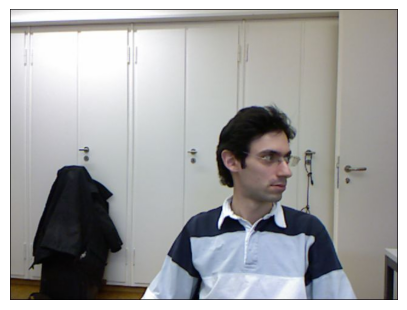

In [6]:
im.show()

In [7]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(get_pose_from_image_name(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [8]:
get_ctr(img_files[0])

tensor([403.4391, 254.6334])

In [9]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=aug_transforms(size=(240,320)),
)

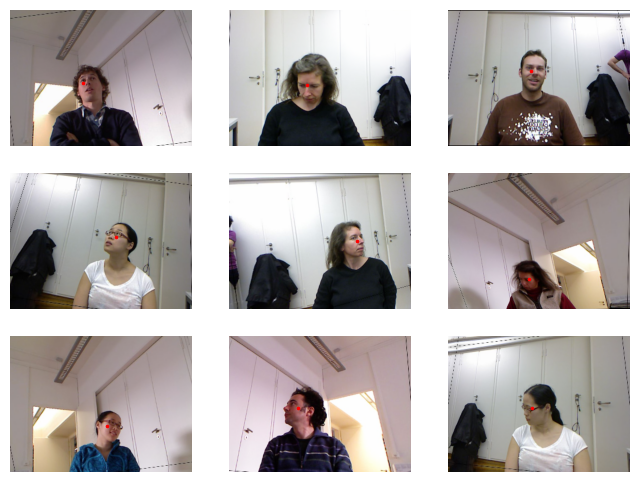

In [10]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [13]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [14]:
yb[0]

TensorPoint([[-0.0182, -0.0537]], device='cuda:0')

In [15]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.0MB/s]


In [17]:
dls.loss_func

FlattenedLoss of MSELoss()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


SuggestedLRs(valley=0.0012022644514217973)

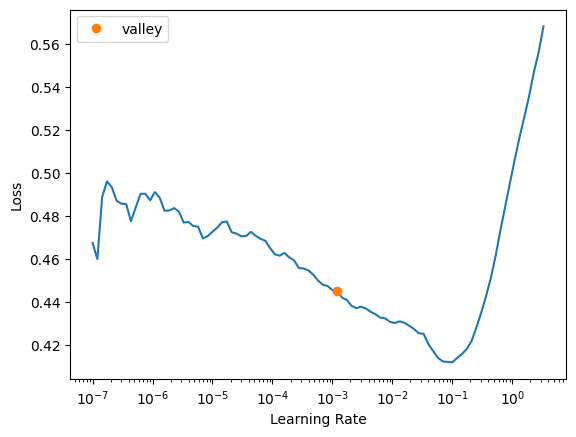

In [18]:
learn.lr_find(suggest_funcs=(slide, valley))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


SuggestedLRs(slide=0.2089296132326126, valley=0.0008317637839354575)

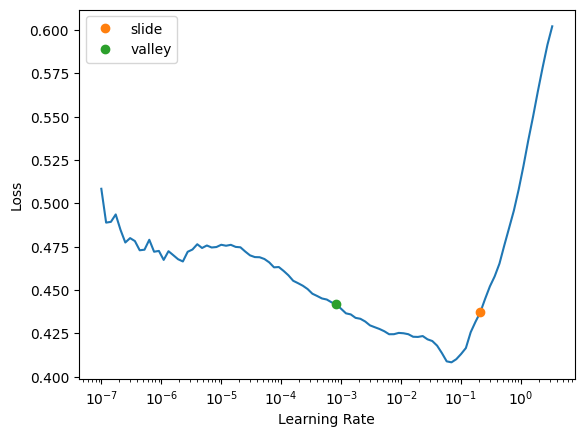

In [20]:
learn.lr_find(suggest_funcs=(slide, valley))

In [21]:
lr = 5e-3
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.057686,0.003196,01:39


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,time
0,0.005732,0.001369,01:43
1,0.002952,0.000992,01:42
2,0.001492,0.000500,01:41


In [22]:
math.sqrt(0.0001)

0.01

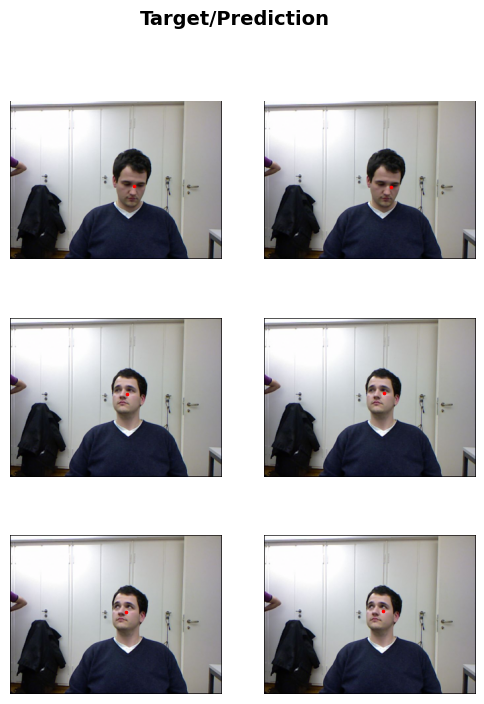

In [23]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

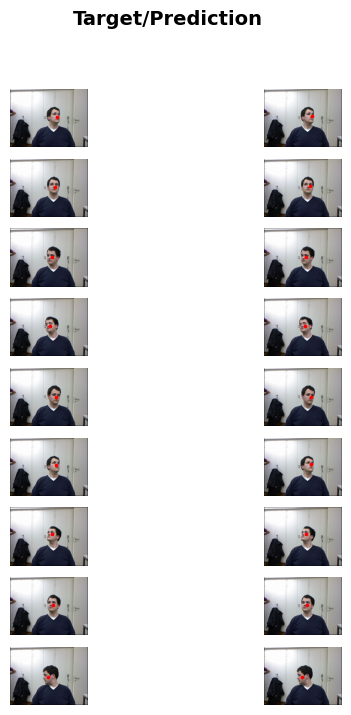

In [24]:
learn.show_results(figsize=(6,8))